In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image
import pandas as pd 


**Brief description of the problem and data (5 pts)**

Briefly describe the challenge problem and NLP. Describe the size, dimension, structure, etc., of the data.

This competition is based around Generative Adversarial Networks. In essence, in this instance, you create two networks. one that can tell the difference  between a real image, and a fake. And another that creates fake images. In this case there is a twist, and that is it will take an image, and try and create the same basic image, but as a monet painting. The basic data structure contains four folders, two of them, sets of image in JPEG format (monet(300), and photos(7038)), the second are the same images in TfRec format (guessing its a tensorflow ready file format). There are no sample output files, the idea is that when the model is finished it will output between 7-10K monet style (at least thransform the 7038 files in photos to their monet equivalents, add more if desired).

In [5]:
# Paths to simplify navigation. 
DATA = '/kaggle/input/gan-getting-started/'
MONET_JPG = os.path.join(DATA, 'monet_jpg')
PHOTO_JPG = os.path.join(DATA, 'photo_jpg')
MONET_TFREC = os.path.join(DATA, 'monet_tfrec')
PHOTO_TFREC = os.path.join(DATA, 'photo_tfrec')

First we will load the photos normally so we can analyse them. 

Number of Monet images: 300
Number of Photo images: 7038


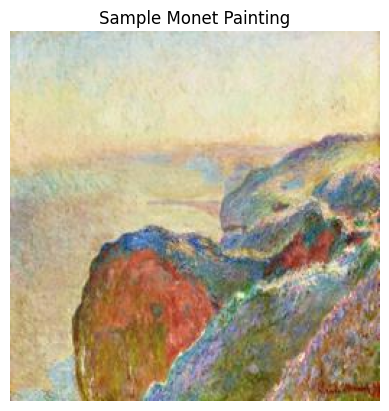

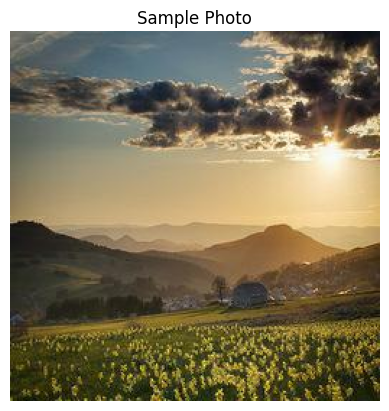

In [6]:
monet_files = sorted(glob.glob(os.path.join(MONET_JPG, '*.jpg')))
photo_files = sorted(glob.glob(os.path.join(PHOTO_JPG, '*.jpg')))

print(f"Number of Monet images: {len(monet_files)}")
print(f"Number of Photo images: {len(photo_files)}")

# Load and display a sample Monet image
sample_monet = load_img(monet_files[0])
plt.imshow(sample_monet)
plt.title("Sample Monet Painting")
plt.axis('off')
plt.show()

# Similarly for a photo
sample_photo = load_img(photo_files[0])
plt.imshow(sample_photo)
plt.title("Sample Photo")
plt.axis('off')
plt.show()

We are going to attempt to use the TFRecs in the model pipeline in hopes of faster training as I am very close to out of GPU time on my account. So here goes nothing!

In [7]:
# Parsing function (from earlier)
def parse_tfrecord(example):
    features = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'image_name': tf.io.FixedLenFeature([], tf.string)
    }
    parsed = tf.io.parse_single_example(example, features)
    image = tf.io.decode_jpeg(parsed['image'], channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0  # [-1,1] norm for GAN stability
    return image

# Augmentation function (simple for now)
def augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

# Build datasets
BATCH_SIZE = 1  # CycleGAN often uses 1 for instance norm; increase if hardware allows
BUFFER_SIZE = 300  # For shuffling Monets (small set)

monet_tfrec_files = sorted(glob.glob(os.path.join(MONET_TFREC, '*.tfrec')))
photo_tfrec_files = sorted(glob.glob(os.path.join(PHOTO_TFREC, '*.tfrec')))

monet_ds = tf.data.TFRecordDataset(monet_tfrec_files)
monet_ds = monet_ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
monet_ds = monet_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
monet_ds = monet_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

photo_ds = tf.data.TFRecordDataset(photo_tfrec_files)
photo_ds = photo_ds.map(parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
photo_ds = photo_ds.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)  # Larger shuffle for photos

# Zip in single dataset
train_ds = tf.data.Dataset.zip((monet_ds, photo_ds))

I0000 00:00:1753936634.141647      10 service.cc:148] XLA service 0x5bbc3da22ee0 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753936634.141687      10 service.cc:156]   StreamExecutor device (0): TPU, 2a886c8
I0000 00:00:1753936634.141691      10 service.cc:156]   StreamExecutor device (1): TPU, 2a886c8
I0000 00:00:1753936634.141695      10 service.cc:156]   StreamExecutor device (2): TPU, 2a886c8
I0000 00:00:1753936634.141698      10 service.cc:156]   StreamExecutor device (3): TPU, 2a886c8
I0000 00:00:1753936634.141701      10 service.cc:156]   StreamExecutor device (4): TPU, 2a886c8
I0000 00:00:1753936634.141703      10 service.cc:156]   StreamExecutor device (5): TPU, 2a886c8
I0000 00:00:1753936634.141706      10 service.cc:156]   StreamExecutor device (6): TPU, 2a886c8
I0000 00:00:1753936634.141709      10 service.cc:156]   StreamExecutor device (7): TPU, 2a886c8


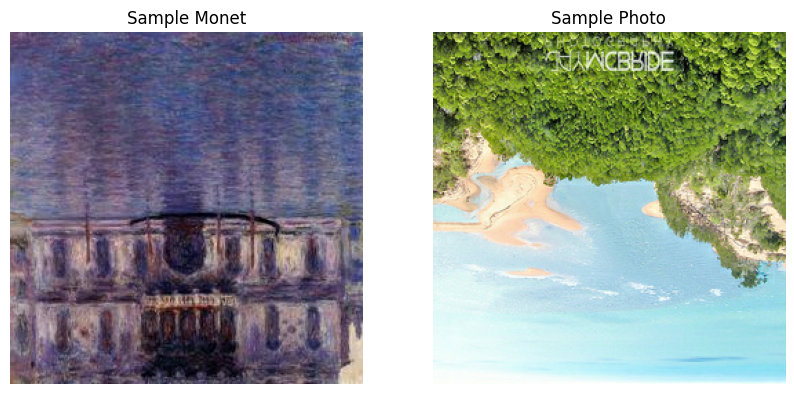

In [8]:
for monet, photo in train_ds.take(1):
    # Visualize Monet sample (denormalize from [-1,1] to [0,1] for display)
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow((monet[0] + 1) / 2)
    plt.title("Sample Monet")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow((photo[0] + 1) / 2)
    plt.title("Sample Photo")
    plt.axis('off')
    
    plt.show()

In [9]:
# Verify shapes and norms
print("Monet shape:", monet.shape)  # Should be (1, 256, 256, 3)
print("Photo shape:", photo.shape)  # Should be (1, 256, 256, 3)
print("Monet min/max:", tf.reduce_min(monet).numpy(), tf.reduce_max(monet).numpy())  # Expect ~ -1 to 1
print("Photo min/max:", tf.reduce_min(photo).numpy(), tf.reduce_max(photo).numpy())  # Expect ~ -1 to 1

Monet shape: (1, 256, 256, 3)
Photo shape: (1, 256, 256, 3)
Monet min/max: -1.0 0.8980392
Photo min/max: -1.0 1.0


TFRec data has been imported, and the train dataset file apears to be working correctly. We will move onto EDA and see if there is anything we can find to analyse the picture data given.

**Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data (15 pts)**

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Next we will inspect the data, check for invalid files, verify picture size is all uniform, visualize a few pictures from each, and maybe plot a few histograms.

In [10]:
def check_images(files):
    invalid = []
    for f in files:
        try:
            img = Image.open(f)
            img.verify()
            img.close()
        except (IOError, SyntaxError):
            invalid.append(f)
    return invalid

invalid_monet = check_images(monet_files)
invalid_photo = check_images(photo_files)
print(f"Invalid Monet: {invalid_monet}")
print(f"Invalid Photos: {invalid_photo}")

Invalid Monet: []
Invalid Photos: []


Next we will verify picture dimensions.

In [11]:
def verify_dimensions(files):
    for f in files:
        img = load_img(f)
        arr = img_to_array(img)
        if arr.shape != (256, 256, 3):
            print(f"Invalid shape for {f}: {arr.shape}")

verify_dimensions(monet_files[:len(monet_files)])

No problems there, all files (256, 256, 3). Next we will plot out a grid of pictures from each set to get a better idea whnat tghe datasets consist of.

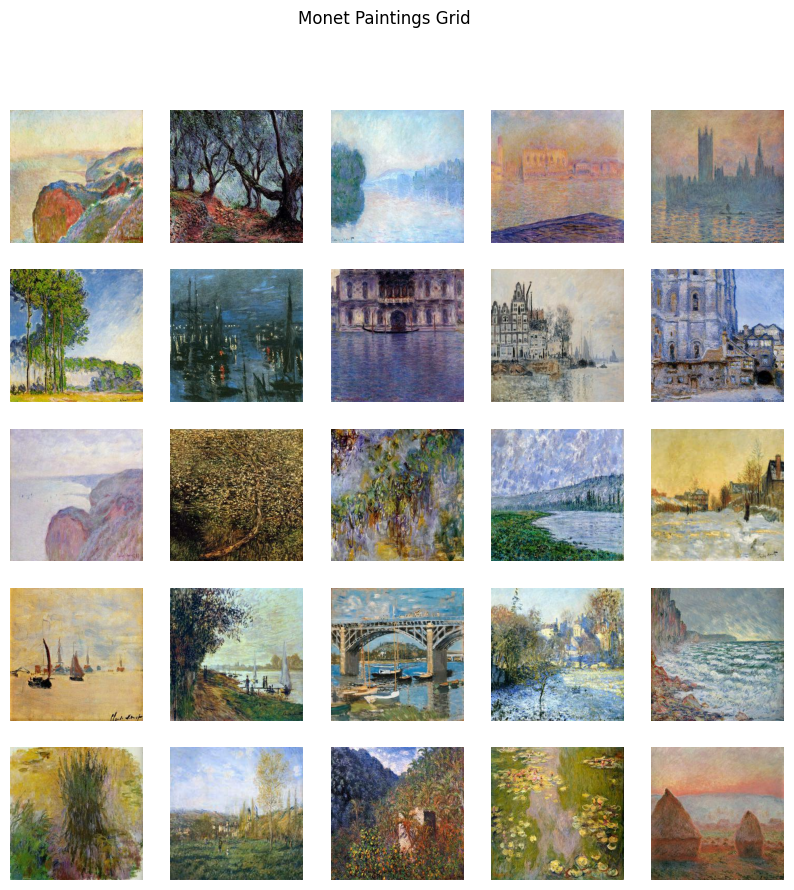

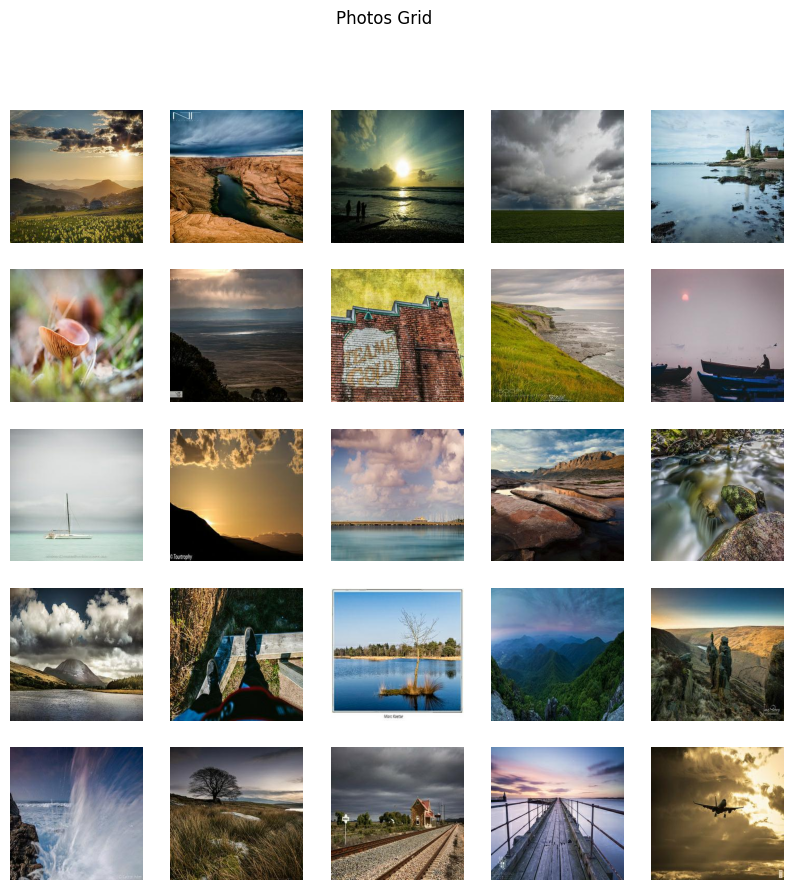

In [12]:
def plot_grid(files, title, n=25):
    plt.figure(figsize=(10, 10))
    for i, f in enumerate(files[:n]):
        plt.subplot(5, 5, i+1)
        img = load_img(f)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_grid(monet_files, "Monet Paintings Grid")
plot_grid(photo_files, "Photos Grid")

And finally we will plot a color histogram to see if there is anything that stands out about the monet paintings vs the real photos.

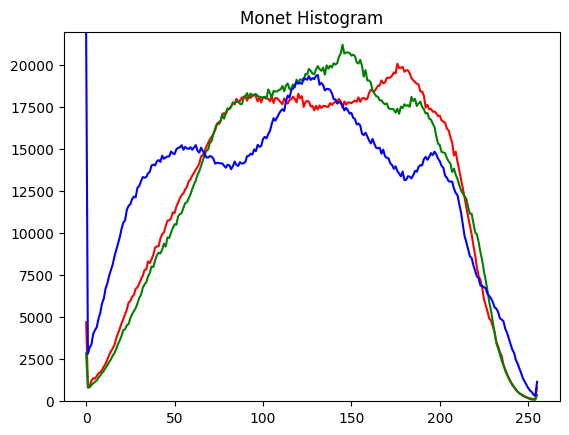

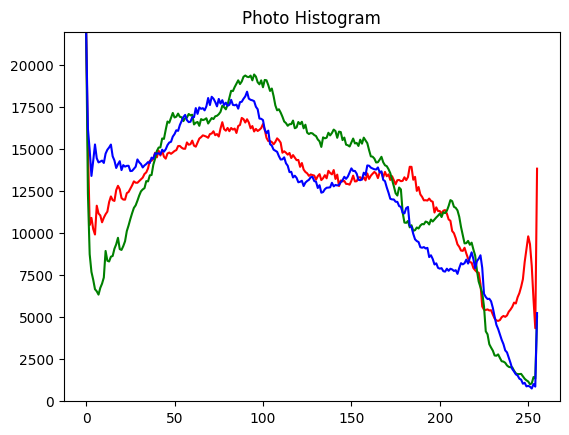

In [13]:
def plot_histogram(files, title, color='rgb', n=50, clip_max=22000):
    images = np.array([img_to_array(load_img(f)) for f in files[:n]])
    plt.figure()
    for i, c in enumerate(color):
        hist = np.histogram(images[..., i].flatten(), bins=256)[0]
        if clip_max is not None:
            hist = np.clip(hist, 0, clip_max) 
        plt.plot(hist, color=c)
    plt.title(title)
    if clip_max is not None:
        plt.ylim(0, clip_max)
    plt.show()

plot_histogram(monet_files, "Monet Histogram")
plot_histogram(photo_files, "Photo Histogram")

One think I find interesting from these histograms is very few blacks or bright colors in the monets, and plenty of blacks in the photos. 

**DModel Architecture (25 pts)**

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

My model will consist of GAN called CycleGan. it is made up of two generators(photo -> monet, Monet -> photo) and two discriminators using the Tensorflow CycleGan tutorial for reference. The "cycle" part refers to a key innovation: translating an image from domain A to B and back to A should reconstruct the original, enforcing structure preservation. Discriminators judge the work of the the generators, pushing them to produce convincing fakes. The model trains via an adversarial game: Generators try to fool discriminators, while discriminators get better at spotting fakes.

In [14]:

from tensorflow.keras import layers

def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    if apply_norm:
        result.add(layers.LayerNormalization())  
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(layers.LayerNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

# Generator: U-Net like
def Generator():
    inputs = layers.Input(shape=[256, 256, 3])
    
    down_stack = [
        downsample(64, 4, apply_norm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]
    
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),  # (bs, 16, 16, 1024)
        upsample(256, 4),  # (bs, 32, 32, 512)
        upsample(128, 4),  # (bs, 64, 64, 256)
        upsample(64, 4),   # (bs, 128, 128, 128)
    ]
    
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(0., 0.02), activation='tanh')  # (bs, 256, 256, 3)
    
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])
    
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# Discriminator: PatchGAN
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[256, 256, 3])
    x = downsample(64, 4, False)(inp)  
    x = downsample(128, 4)(x) 
    x = downsample(256, 4)(x)  
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x)  # (bs, 31, 31, 512)
    x = layers.LayerNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)
    x = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x)  # (bs, 30, 30, 1)
    return tf.keras.Model(inputs=inp, outputs=x)

# Instantiate
# Photo to Monet
gen_G = Generator()  
# Monet to Photo
gen_F = Generator()  
# For photos
disc_X = Discriminator() 
# For Monets
disc_Y = Discriminator()


**Results and Analysis (35 pts)**

Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

I will train my model on as much time that I have left on my GPU quota. Should get 50 epochs out of it, and then I will save the set of photos and submit them to be scored by kaggles MiFID scoreing system. 

I did some light tuning with the hyper parameters of the lambda (cycle loss wight) and the generator and discriminator optimizers. Hard to tell How much effect this had on the outcome as the training time is so high, The VM 3-8 TPU arn't helping reduce training time, and I am completely out of GPU accelerator time for the week. I am happy with the visual result from this project. But whe I try to submit the zip file with the 7300 jpg images it gets rejected. I am out of time, and do not know why this is happening, the file downloads fine, I am able to open it on my computer and view the images. They are the right size, but still it refuses to judge my entry. I am afraid I will have to call it her for now as this assignment is already a day late. 

Epoch 1: Gen loss 4.9729108810424805, Disc loss 0.39675411581993103


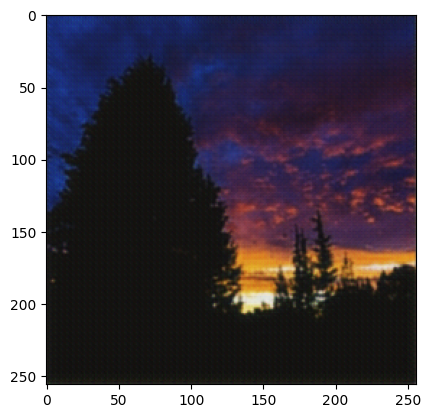

Epoch 2: Gen loss 2.8740897178649902, Disc loss 0.5716662406921387


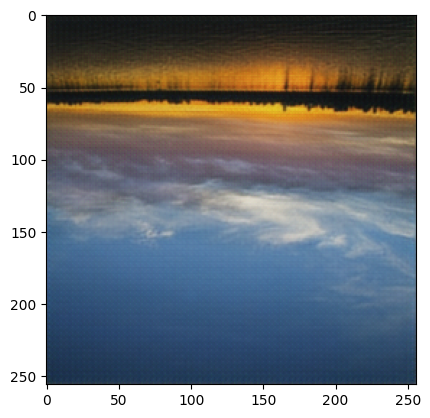

Epoch 3: Gen loss 3.32576322555542, Disc loss 0.3391726613044739


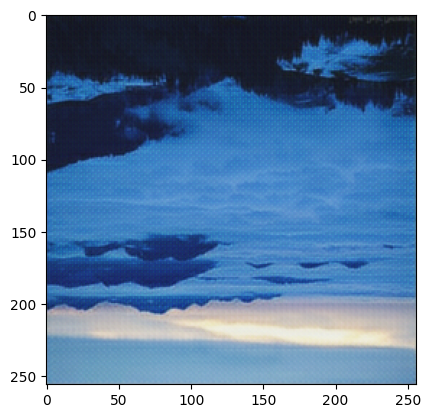

Epoch 4: Gen loss 3.311398506164551, Disc loss 0.9656479954719543


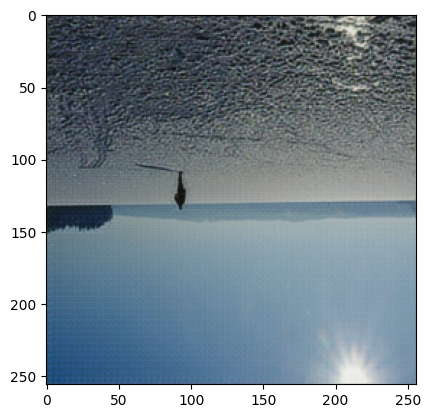

Epoch 5: Gen loss 3.9503209590911865, Disc loss 0.7374622225761414


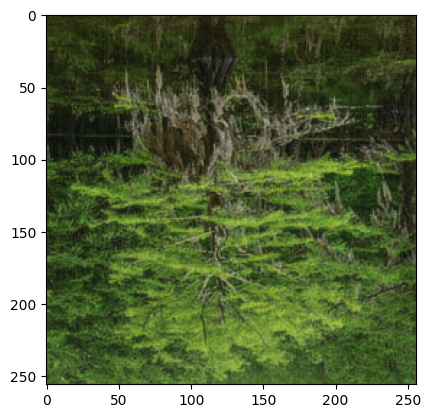

In [16]:

LAMBDA = 10 

loss_obj = tf.keras.losses.MeanSquaredError() 

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image)) * LAMBDA

def identity_loss(real_image, same_image):
    return tf.reduce_mean(tf.abs(real_image - same_image)) * LAMBDA * 0.5 

# Optimizers
gen_G_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_F_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_X_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_Y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Training step (use @tf.function for speed)
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G: x -> y
        fake_y = gen_G(real_x, training=True)
        cycled_x = gen_F(fake_y, training=True)
        
        # Generator F: y -> x
        fake_x = gen_F(real_y, training=True)
        cycled_y = gen_G(fake_x, training=True)
        
        # Identity
        same_x = gen_F(real_x, training=True)
        same_y = gen_G(real_y, training=True)
        
        # Discriminators
        disc_real_x = disc_X(real_x, training=True)
        disc_real_y = disc_Y(real_y, training=True)
        disc_fake_x = disc_X(fake_x, training=True)
        disc_fake_y = disc_Y(fake_y, training=True)
        
        # Losses
        gen_G_loss = generator_loss(disc_fake_y) + calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) + identity_loss(real_y, same_y)
        gen_F_loss = generator_loss(disc_fake_x) + calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y) + identity_loss(real_x, same_x)
        total_gen_loss = gen_G_loss + gen_F_loss
        
        disc_X_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_Y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    
    # Gradients
    gen_G_grads = tape.gradient(gen_G_loss, gen_G.trainable_variables)
    gen_F_grads = tape.gradient(gen_F_loss, gen_F.trainable_variables)
    disc_X_grads = tape.gradient(disc_X_loss, disc_X.trainable_variables)
    disc_Y_grads = tape.gradient(disc_Y_loss, disc_Y.trainable_variables)
    
    # Apply
    gen_G_optimizer.apply_gradients(zip(gen_G_grads, gen_G.trainable_variables))
    gen_F_optimizer.apply_gradients(zip(gen_F_grads, gen_F.trainable_variables))
    disc_X_optimizer.apply_gradients(zip(disc_X_grads, disc_X.trainable_variables))
    disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, disc_Y.trainable_variables))
    
    return total_gen_loss, disc_X_loss + disc_Y_loss

# Training loop
EPOCHS = 5 
for epoch in range(EPOCHS):
    for real_monet, real_photo in train_ds:  # Note: Adjust if zipped differently
        gen_loss, disc_loss = train_step(real_photo, real_monet)  # Photo as x, Monet as y
    print(f"Epoch {epoch+1}: Gen loss {gen_loss}, Disc loss {disc_loss}")
    
    # Save checkpoints every 10 epochs (use tf.train.Checkpoint)
    if (epoch + 1) % 10 == 0:
        # TODO: Implement checkpointing
        pass
    
    # Generate sample images for monitoring
    sample_photo = next(iter(photo_ds.take(1)))
    fake_monet = gen_G(sample_photo)
    plt.imshow((fake_monet[0] + 1) / 2)
    plt.show()


Failed to save the notebook before trying to submit it and it deleted the model, and all pictures for the 50 epoch run I did. The output zip file was saved, but it did not submit properly. Will need to revisit this when I have more time. Ran a quick 5 epoch run to show photos and loses. Takes about 10 minutes per photo without the accelerator.

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from PIL import Image
import os
import glob
import zipfile

def load_image(file_path):
    img = load_img(file_path, target_size=(256, 256))
    img = img_to_array(img)
    img = (img / 127.5) - 1.0  # Normalize to [-1, 1] for GAN input
    return img

# Now your code
os.makedirs('tmp', exist_ok=True)
for i, photo_path in enumerate(photo_files):
    photo = load_image(photo_path)
    photo = np.expand_dims(photo, 0)  # Add batch dimension
    generated = gen_G(photo)[0]  # Generate
    generated = (generated * 127.5 + 127.5).numpy().astype(np.uint8)  # Denormalize to [0, 255]
    img = Image.fromarray(generated)
    img.save(f'images/{i+1}.jpg')

with zipfile.ZipFile('images.zip', 'w') as z:
    for f in glob.glob('tmp/*.jpg'):
        z.write(f)

**Conclusion (15 pts)**

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

Results really did look pretty good, I was short on time, and all but out of gpu processing time on kaggle, but the pictures generated actually did look really dcool, and I could see how with enough training and tuning this could create an apreciable fake monet from a pictuire. Takeaways from this one for starters are GAN models are very powerful, capable of producing some very impressive images. By pitting a fake detecting agent against a fake creating network with enough time and training the results are pretty amazing. I did have fun with this type of model, and I will definately be revisit it in the future. Improvements to start with, I would try to make an automatic pipeline for hyperparameter tuning. Something like the callbacks that can automatically adjust settings in betweeen epochs. For next time the biggest issue I think I am going to have to address is the zip file creation. I did simple numbers for the file names, and I am nott sure if that is the issue. The files may need the original names from the coresponding photos. So that is on the agenda for next time. 